# Unit Commitment Problem with Machine Learning
In this notebook, we solve a unit commitment problem for a power system using optimization and machine learning. We use binary classification to predict the on/off status of each generator based on system conditions, aiming to accelerate the unit commitment process.

In [1]:
import numpy as np
from gurobipy import Model, GRB, quicksum
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Step 1: Define the Unit Commitment Model

                     N1  N2  N3  N4  N5  N6
2019-01-01 00:00:00  10  15  20  25  30  35
2019-01-01 01:00:00  20  25  30  35  40  45
2019-01-01 02:00:00  30  35  40  45  50  55
查找到的值: 25


## Step 2: Data Preparation - Generating Synthetic Data

## Generate Load data based on nominal load with fluctuate

In [2]:
import numpy as np
import pandas as pd

# Define constants
nominal_load_1 = 56
nominal_load_2 = 112
nominal_load_3 = 112
hours_per_year = 365 * 24

# Adding sinusoidal daily cycle and random noise for variability
time = np.arange(hours_per_year)
daily_cycle = 0.2 * np.sin(2 * np.pi * time / 24)  # Daily sinusoidal pattern (20% amplitude)
seasonal_cycle = 0.1 * np.sin(2 * np.pi * time / (24 * 30))  # Monthly sinusoidal pattern (10% amplitude)
seasonal_cycle_2 = 0.1 * np.sin(3 * np.pi * time / (24 * 30)) 
random_noise = np.random.normal(0, 0.05, hours_per_year)  # Random noise
random_noise_3 = np.random.normal(0, 0.1, hours_per_year) 
# Calculate hourly load
# hourly_load_1 = nominal_load_1 * (1 + daily_cycle + seasonal_cycle + random_noise)
# hourly_load_2 = nominal_load_2 * (1 + daily_cycle + seasonal_cycle_2 + random_noise)
# hourly_load_3 = nominal_load_3 * (1 + daily_cycle + seasonal_cycle + random_noise_3)

hourly_load_1 = np.clip(np.random.normal(0.5 * nominal_load_1, 0.15 * nominal_load_1, hours_per_year), 0, nominal_load_1)
hourly_load_2 = np.clip(np.random.normal(0.5 * nominal_load_2, 0.15 * nominal_load_2, hours_per_year), 0, nominal_load_2)
hourly_load_3 = np.clip(np.random.normal(0.5 * nominal_load_3, 0.15 * nominal_load_3, hours_per_year), 0, nominal_load_3)
# Create DataFrame with timestamps
dates = pd.date_range(start="2019-01-01", periods=hours_per_year, freq="H")
load_data = pd.DataFrame({"Timestamp": dates, "Hourly_Load_1": hourly_load_1, "Hourly_Load_2": hourly_load_2, "Hourly_Load_3": hourly_load_3})



## Generate Wind Power data from Website

In [1]:
ninja_wind_1 = pd.read_csv(r"/Users/saule/Documents/Documents - Saule’s MacBook Pro/uniM5/46765 ML for energy sytems/Assignment 2/MLA2/Assignment 2/ninja_wind_55.0582_15.1174_10.csv")
ninja_wind_2 = pd.read_csv(r"/Users/saule/Documents/Documents - Saule’s MacBook Pro/uniM5/46765 ML for energy sytems/Assignment 2/MLA2/Assignment 2/ninja_wind_55.2402_14.7831_30.csv")

# Rename 'time' column to 'Timestamp' in both datasets for consistency
ninja_wind_1.rename(columns={"time": "Timestamp"}, inplace=True)
ninja_wind_2.rename(columns={"time": "Timestamp"}, inplace=True)

# Convert 'Timestamp' columns to datetime format
ninja_wind_1['Timestamp'] = pd.to_datetime(ninja_wind_1['Timestamp'], format='%Y/%m/%d %H:%M')
ninja_wind_2['Timestamp'] = pd.to_datetime(ninja_wind_2['Timestamp'], format='%Y/%m/%d %H:%M')

plt.figure(figsize=(12, 6))
plt.plot(ninja_wind_1['Timestamp'], ninja_wind_1['power'], label='Ninja Wind 1', color='blue')
plt.plot(ninja_wind_2['Timestamp'], ninja_wind_2['power'], label='Ninja Wind 2', color='green')

# Adding title and labels
plt.title('Wind Power Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Power (MW)')  # Adjust the unit if different

# Show legend
plt.legend()

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Merging all data based on 'Timestamp'
merged_data = pd.merge(load_data, ninja_wind_1, on="Timestamp", how="outer")
merged_data = pd.merge(merged_data, ninja_wind_2, on="Timestamp", how="outer", suffixes=('_W1', '_W2'))

merged_data['N1'] = 0
merged_data['N2'] = 0
merged_data['N3'] = 0
merged_data['N4'] = merged_data['Hourly_Load_1'] - merged_data['power_W1']
merged_data['N5'] = merged_data['Hourly_Load_2'] - merged_data['power_W2']
merged_data['N6'] = merged_data['Hourly_Load_3']

# Convert specified columns to dictionary format
merged_data_dict = {
    "N1": merged_data["N1"].tolist(),
    "N2": merged_data["N2"].tolist(),
    "N3": merged_data["N3"].tolist(),
    "N4": merged_data["N4"].tolist(),
    "N5": merged_data["N5"].tolist(),
    "N6": merged_data["N6"].tolist()
}


D_nt_df = pd.DataFrame(merged_data_dict, index=dates)

# value = D_nt_df.loc["2019-01-01 01:00:00", "N4"]
print(D_nt_df )



NameError: name 'pd' is not defined

## Step 1: Define the Unit Commitment Model

In [ ]:


G = ["G1", "G2", "G3"] 
T = dates
daily_time_blocks = [T[i:i+24] for i in range(0, len(T), 24)]

N = ["N1", "N2", "N3" , "N4" , "N5", "N6"] 
L = ["L1", "L2", "L3" , "L4" , "L5", "L6", "L7"]


# D_nt_df.set_index(['Timestamp', 'N'], inplace=True)
B = [
    [0, -0.68197, -0.65018, -0.48266, -0.51445, -0.63472],
    [0, 0.146043, -0.75311, -0.22164, -0.32249, -0.70405],
    [0, -0.31803, -0.34982, -0.51734, -0.48555, -0.36528],
    [0, 0.17199, 0.102932, -0.26102, -0.19196, 0.069337],
    [0, -0.14604, -0.24689, 0.221642, -0.67751, -0.29595],
    [0, -0.14604, -0.24689, 0.221642, 0.322485, -0.29595],
    [0, 0.146043, 0.246886, -0.22164, -0.32249, -0.70405]
]
max_production = [220, 100, 70]
transmission_capacity = [200, 100, 100, 100, 100, 100, 100]
min_down_time = [4,2,1]
min_production = [100, 10, 10]
min_up_time = [4,3,1]
production_cost = [20.655, 16.7, 22.545]
ramping_rate = [55, 50, 20]
start_up_cost = [900,550,170]
generator_data = pd.DataFrame({
    'Max_Production': max_production,
    'Min_Down_Time': min_down_time,
    'Min_Production': min_production,
    'Min_Up_Time': min_up_time,
    'Production_Cost': production_cost,
    'Ramping_Rate': ramping_rate,
    'Start_Up_Cost': start_up_cost
}, index=G)
B_df = pd.DataFrame(B, index=L, columns=N)
transmission_capacity_df = pd.DataFrame({
    'Transmission_Capacity': transmission_capacity
}, index=L)

Load_1 = merged_data['Hourly_Load_1']
Load_2 = merged_data['Hourly_Load_2']
Load_3 = merged_data['Hourly_Load_3']
P_W1 = merged_data['power_W1']
P_W2 = merged_data['power_W2']


u_values = {}
p_values = {}
daily_min_costs = []


for day, daily_T in enumerate(daily_time_blocks):
    # print(daily_T)
    # D_nt_df.index = pd.to_datetime(D_nt_df.index)
    # daily_T = pd.DatetimeIndex(daily_T)
    # print(type(D_nt_df.index))
    # print(type(daily_T[0])) 
    # print(daily_T[0])
    
    # for n in N:
    #     for t in daily_T:
    #         print(D_nt_df.loc[daily_T[0], n])
   


    model = Model(f"DailyOptimization_Day{day+1}")

    M = 10000
    # p, p_nt
    p = model.addVars(G, daily_T, lb=0,name="p")
    p_nt = model.addVars(N, daily_T, lb=0, name="p_nt")
    u = model.addVars(G, daily_T, vtype=GRB.BINARY, name="u")    # on/off
    # u = model.addVars(G, daily_T, lb=0, ub = 1, name="u")
    s = model.addVars(G, daily_T, lb=0, name="s")                # start-up cost
    epsilon = model.addVars(N, daily_T, lb=0, name="epsilon") 
    delta = model.addVars(N, daily_T, lb=0, name="delta")   



    # Objective function
    model.setObjective(
        (quicksum((generator_data.loc[g,'Production_Cost'] * p[g,t] + s[g, t]) for g in G for t in daily_T) + 
        M * quicksum(epsilon[n, t] + delta[n, t] for n in N for t in daily_T)),
        GRB.MINIMIZE
    )
    # Constraints for generation
    for g in G:
        for t in daily_T:
            model.addConstr(generator_data.loc[g, 'Min_Production'] * u[g, t] <= p[g,t])
            model.addConstr(p[g, t] <= generator_data.loc[g, 'Max_Production'] * u[g, t])

    # balancing constraint
    for t in daily_T:
        model.addConstr(quicksum(p[g,t] for g in G) == quicksum(D_nt_df.loc[t, n] + epsilon[n, t] - delta[n, t] for n in N))

    # Transmission limition


    transmission_expr = quicksum(B_df.loc[l, n] * (p_nt[n, t] - D_nt_df.loc[t, n] - epsilon[n, t] + delta[n, t]) for n in N)
        

    for l in L:
        for t in daily_T:
            model.addConstr(
                                quicksum(B_df.loc[l, n] * (p_nt[n, t] - D_nt_df.loc[t, n] - epsilon[n, t] + delta[n, t]) for n in N) >= 
                                -transmission_capacity_df.loc[l, 'Transmission_Capacity']
                            )
            model.addConstr(
                quicksum(B_df.loc[l, n] * (p_nt[n, t] - D_nt_df.loc[t, n] - epsilon[n, t] + delta[n, t]) for n in N) <= 
                transmission_capacity_df.loc[l, 'Transmission_Capacity']
            )
            
    # combine p_gt with p_nt
    for t in daily_T:
        model.addConstr(p_nt["N1", t] == p["G1", t], name=f"Link_G1_N1_t{t}")
        model.addConstr(p_nt["N2", t] == p["G2", t], name=f"Link_G2_N2_t{t}")
        model.addConstr(p_nt["N6", t] == p["G3", t], name=f"Link_G3_N6_t{t}")
        model.addConstr(p_nt["N3", t] == 0, name=f"Set_N3_Zero_t{t}")
        model.addConstr(p_nt["N4", t] == 0, name=f"Set_N4_Zero_t{t}")
        model.addConstr(p_nt["N5", t] == 0, name=f"Set_N5_Zero_t{t}")


    # start-up constraint
    for g in G:
        for t_idx, t in enumerate(daily_T):
            if t_idx == 0:
                # if there is data in the previous day use the final data of previous day
                if day > 0:
                    prev_day_last_t = daily_time_blocks[day - 1][-1]
                    model.addConstr(s[g, t] >= generator_data.loc[g, 'Start_Up_Cost'] * (u[g, t] - u_values[(g, prev_day_last_t)] ))
                # if there is no data in the previous day, no constraint
            else:
                # if t>0 use data in same day
                prev_t = daily_T[t_idx - 1]
                model.addConstr(s[g, t] >= generator_data.loc[g, 'Start_Up_Cost'] * (u[g, t] - u[g, prev_t]))

    # ramping rate constraint
    for g in G:
        for t_idx, t in enumerate(daily_T):
            if t_idx == 0:
                if day > 0:
                    prev_day_last_t = daily_time_blocks[day - 1][-1]
                    model.addConstr(p[g, t] - p_values[(g, prev_day_last_t)] >= -generator_data.loc[g, 'Ramping_Rate'])
                    model.addConstr(p[g, t] - p_values[(g, prev_day_last_t)] <= generator_data.loc[g, 'Ramping_Rate'])
            else:
                prev_t = daily_T[t_idx - 1]
                model.addConstr(p[g, t] - p[g, prev_t] >= -generator_data.loc[g, 'Ramping_Rate'])
                model.addConstr(p[g, t] - p[g, prev_t] <= generator_data.loc[g, 'Ramping_Rate'])
    # min-up-time constraint
    for g in G:
        for t_idx, t in enumerate(daily_T):
            max_t_in_day = daily_T[-1]
            tau_range = pd.date_range(
            start=t, 
            end=min(t + pd.Timedelta(hours=generator_data.loc[g, 'Min_Up_Time'] - 1), max_t_in_day), 
            freq='H'
        )
            # if it is the first hour of the day
            if t_idx == 0:
                if day > 0:
                    prev_day_last_t = daily_time_blocks[day - 1][-1]
                    for tau in tau_range:
                        model.addConstr(
                            -u_values[(g, prev_day_last_t)] + u[g, t] - u[g, tau] <= 0
                        )
                else:
                    continue
            else:
                # if not the first hour of the day
                prev_t = daily_T[t_idx - 1]
                for tau in tau_range:
                    model.addConstr(
                        -u[g, prev_t] + u[g, t] - u[g, tau] <= 0
                    )

    # min-down-time constraint
    for g in G:
        for t_idx, t in enumerate(daily_T):
            max_t_in_day = daily_T[-1]
            tau_range = pd.date_range(
            start=t, 
            end=min(t + pd.Timedelta(hours=generator_data.loc[g, 'Min_Down_Time'] - 1), max_t_in_day), 
            freq='H'
        )
            # if it is the first hour of the day
            if t_idx == 0:
                if day > 0:
                    prev_day_last_t = daily_time_blocks[day - 1][-1]
                    for tau in tau_range:
                        model.addConstr(
                            u_values[(g, prev_day_last_t)] - u[g, t] + u[g, tau] <= 0
                        )
                else:
                    continue
            else:
                # if not the first hour of the day
                prev_t = daily_T[t_idx - 1]
                
                for tau in tau_range:
                    model.addConstr(
                        u[g, prev_t] - u[g, t] + u[g, tau] <= 1
                    )

    # solve the model
    model.optimize()
    if model.status == GRB.OPTIMAL:
        
        for g in G:
            for t in daily_T:
                u_values[(g, t)] = u[g, t].X
                p_values[(g, t)] = p[g, t].X
                print(f"Generator {g} at time {t}: Production = {p[g, t].X}, Status = {u[g, t].X}")
    else:
        print("No optimal solution found.")
    # find if it is feasibility
# # 检查是否找到可行解
#     if model.status == GRB.OPTIMAL:
#         print("Optimal solution found.")
        
#         # 输出生成机的生产量和状态
#         for g in G:
#             for t in daily_T:
#                 print(f"Generator {g} at time {t}: Production = {p[g, t].X}, Status = {u[g, t].X}")

#         # 输出 p_nt 变量的值
#         for n in N:
#             for t in daily_T:
#                 print(f"p_nt[{n}, {t}] = {p_nt[n, t].X}")
        
#         # 输出 s 变量的值（启动成本）
#         for g in G:
#             for t in daily_T:
#                 print(f"s[{g}, {t}] = {s[g, t].X}")

#         # 输出 epsilon 和 delta 变量的值
#         for n in N:
#             for t in daily_T:
#                 print(f"epsilon[{n}, {t}] = {epsilon[n, t].X}")
#                 print(f"delta[{n}, {t}] = {delta[n, t].X}")

#         # 输出 u_values 和 p_values 的字典，方便在下一天继续使用
#         for g in G:
#             for t in daily_T:
#                 u_values[(g, t)] = u[g, t].X
#                 p_values[(g, t)] = p[g, t].X

#         # 输出每日最小成本
#         daily_min_cost = model.ObjVal
#         daily_min_costs.append(daily_min_cost)
#         print(f"Minimum cost for day  {day + 1}: {daily_min_cost}")

#     else:
#         print("No optimal solution found.")



    

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-12500H, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1184 rows, 648 columns and 7098 nonzeros
Model fingerprint: 0x96d46542
Variable types: 576 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [7e-02, 9e+02]
  Objective range  [1e+00, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 970526.25024
Presolve removed 431 rows and 193 columns
Presolve time: 0.01s
Presolved: 753 rows, 455 columns, 5427 nonzeros
Variable types: 360 continuous, 95 integer (95 binary)

Root relaxation: objective 5.131844e+04, 166 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

KeyError: ('G1', Timestamp('2019-01-02 23:00:00'))

## Optimization For signal day

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-12500H, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1184 rows, 648 columns and 7098 nonzeros
Model fingerprint: 0x9b9cc84b
Variable types: 576 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [7e-02, 9e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 263940.87416
Presolve removed 431 rows and 193 columns
Presolve time: 0.01s
Presolved: 753 rows, 455 columns, 5427 nonzeros
Variable types: 360 continuous, 95 integer (95 binary)

Root relaxation: objective 4.630248e+04, 163 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

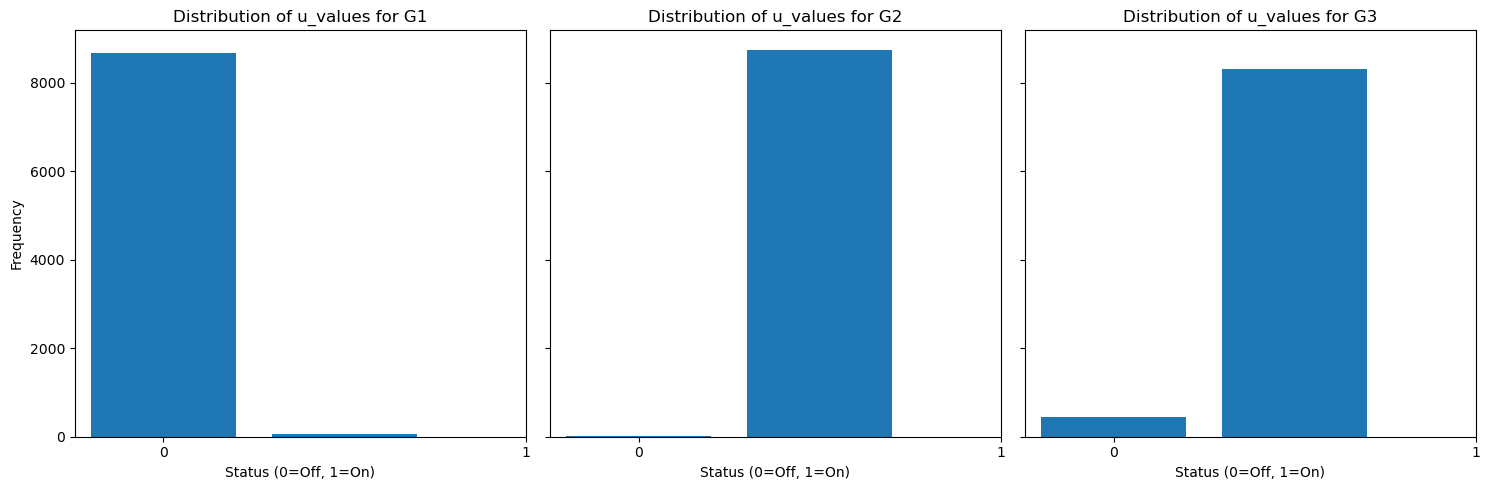

In [8]:
G = ["G1", "G2", "G3"] 
T = dates
daily_time_blocks = [T[i:i+24] for i in range(0, len(T), 24)]

N = ["N1", "N2", "N3", "N4", "N5", "N6"] 
L = ["L1", "L2", "L3", "L4", "L5", "L6", "L7"]

B = [
    [0, -0.68197, -0.65018, -0.48266, -0.51445, -0.63472],
    [0, 0.146043, -0.75311, -0.22164, -0.32249, -0.70405],
    [0, -0.31803, -0.34982, -0.51734, -0.48555, -0.36528],
    [0, 0.17199, 0.102932, -0.26102, -0.19196, 0.069337],
    [0, -0.14604, -0.24689, 0.221642, -0.67751, -0.29595],
    [0, -0.14604, -0.24689, 0.221642, 0.322485, -0.29595],
    [0, 0.146043, 0.246886, -0.22164, -0.32249, -0.70405]
]
max_production = [220, 100, 70]
transmission_capacity = [200, 100, 100, 100, 100, 100, 100]
min_down_time = [4,2,1]
min_production = [100, 10, 10]
min_up_time = [4,3,1]
production_cost = [20.655, 16.7, 22.545]
ramping_rate = [55, 50, 20]
start_up_cost = [900, 550, 170]

generator_data = pd.DataFrame({
    'Max_Production': max_production,
    'Min_Down_Time': min_down_time,
    'Min_Production': min_production,
    'Min_Up_Time': min_up_time,
    'Production_Cost': production_cost,
    'Ramping_Rate': ramping_rate,
    'Start_Up_Cost': start_up_cost
}, index=G)

B_df = pd.DataFrame(B, index=L, columns=N)
transmission_capacity_df = pd.DataFrame({
    'Transmission_Capacity': transmission_capacity
}, index=L)

Load_1 = merged_data['Hourly_Load_1']
Load_2 = merged_data['Hourly_Load_2']
Load_3 = merged_data['Hourly_Load_3']
P_W1 = merged_data['power_W1']
P_W2 = merged_data['power_W2']

u_values = {}
p_values = {}
daily_min_costs = []

# 定义一个字典来存储每小时的Transmission Limitation值
transmission_values = {}

day = 0  
daily_T = daily_time_blocks[0]
for day, daily_T in enumerate(daily_time_blocks):
    model = Model(f"DailyOptimization_Day{day+1}")

    M = 100

    # p, p_nt
    p = model.addVars(G, daily_T, lb=0, name="p")
    p_nt = model.addVars(N, daily_T, lb=0, name="p_nt")
    u = model.addVars(G, daily_T, vtype=GRB.BINARY, name="u")    # on/off
    s = model.addVars(G, daily_T, lb=0, name="s")                # start-up cost
    epsilon = model.addVars(N, daily_T, lb=0, name="epsilon") 
    delta = model.addVars(N, daily_T, lb=0, name="delta")

    # Objective function
    model.setObjective(
        (quicksum((generator_data.loc[g, 'Production_Cost'] * p[g, t] + s[g, t]) for g in G for t in daily_T) + 
        M * quicksum(epsilon[n, t] + delta[n, t] for n in N for t in daily_T)),
        GRB.MINIMIZE
    )

    # Constraints for generation
    for g in G:
        for t in daily_T:
            model.addConstr(generator_data.loc[g, 'Min_Production'] * u[g, t] <= p[g, t])
            model.addConstr(p[g, t] <= generator_data.loc[g, 'Max_Production'] * u[g, t])

    # balancing constraint
    for t in daily_T:
        model.addConstr(quicksum(p[g, t] for g in G) == quicksum(D_nt_df.loc[t, n] + epsilon[n, t] - delta[n, t] for n in N))

    # Transmission limitation with value tracking
    for l in L:
        for t in daily_T:
            
            transmission_expr = quicksum(B_df.loc[l, n] * (p_nt[n, t] - D_nt_df.loc[t, n] - epsilon[n, t] + delta[n, t]) for n in N)
            
            
            model.addConstr(transmission_expr >= -transmission_capacity_df.loc[l, 'Transmission_Capacity'], 
                            name=f"Transmission_Limitation_Lower_{l}_{t}")
            model.addConstr(transmission_expr <= transmission_capacity_df.loc[l, 'Transmission_Capacity'], 
                            name=f"Transmission_Limitation_Upper_{l}_{t}")
            
            
            transmission_values[(l, t)] = transmission_expr

    # combine p_gt with p_nt
    for t in daily_T:
        model.addConstr(p_nt["N1", t] == p["G1", t], name=f"Link_G1_N1_t{t}")
        model.addConstr(p_nt["N2", t] == p["G2", t], name=f"Link_G2_N2_t{t}")
        model.addConstr(p_nt["N6", t] == p["G3", t], name=f"Link_G3_N6_t{t}")
        model.addConstr(p_nt["N3", t] == 0, name=f"Set_N3_Zero_t{t}")
        model.addConstr(p_nt["N4", t] == 0, name=f"Set_N4_Zero_t{t}")
        model.addConstr(p_nt["N5", t] == 0, name=f"Set_N5_Zero_t{t}")

    # start-up constraint
    for g in G:
        for t_idx, t in enumerate(daily_T):
            if t_idx == 0:
               continue
            else:
                # if t>0 use data in same day
                prev_t = daily_T[t_idx - 1]
                model.addConstr(s[g, t] >= generator_data.loc[g, 'Start_Up_Cost'] * (u[g, t] - u[g, prev_t]))

    # ramping rate constraint
    for g in G:
        for t_idx, t in enumerate(daily_T):
            if t_idx == 0:
                continue
            else:
                prev_t = daily_T[t_idx - 1]
                model.addConstr(p[g, t] - p[g, prev_t] >= -generator_data.loc[g, 'Ramping_Rate'])
                model.addConstr(p[g, t] - p[g, prev_t] <= generator_data.loc[g, 'Ramping_Rate'])
    # min-up-time constraint
    for g in G:
        for t_idx, t in enumerate(daily_T):
            max_t_in_day = daily_T[-1]
            tau_range = pd.date_range(
            start=t, 
            end=min(t + pd.Timedelta(hours=generator_data.loc[g, 'Min_Up_Time'] - 1), max_t_in_day), 
            freq='H'
        )
            # if it is the first hour of the day
            if t_idx == 0:
                continue
            else:
                # if not the first hour of the day
                prev_t = daily_T[t_idx - 1]
                for tau in tau_range:
                    model.addConstr(
                        -u[g, prev_t] + u[g, t] - u[g, tau] <= 0
                    )
    # min-down-time constraint
    for g in G:
        for t_idx, t in enumerate(daily_T):
            max_t_in_day = daily_T[-1]
            tau_range = pd.date_range(
            start=t, 
            end=min(t + pd.Timedelta(hours=generator_data.loc[g, 'Min_Down_Time'] - 1), max_t_in_day), 
            freq='H'
        )
            # if it is the first hour of the day
            if t_idx == 0:
                continue
            else:
                # if not the first hour of the day
                prev_t = daily_T[t_idx - 1]
                
                for tau in tau_range:
                    model.addConstr(
                        u[g, prev_t] - u[g, t] + u[g, tau] <= 1
                    )

    # Solve the model
    model.optimize()

    # Output results
    if model.status == GRB.OPTIMAL:
        # calculate transmission value
        # print("Transmission Limitation Values:")
        # for (l, t), expr in transmission_values.items():
        #     # 计算表达式的实际值
        #     calculated_value = expr.getValue()
        #     print(f"Line {l}, Time {t}: Transmission Value = {calculated_value}")

        # 
        for g in G:
            for t in daily_T:
                u_values[(g, t)] = u[g, t].X
                p_values[(g, t)] = p[g, t].X
                print(f"Generator {g} at time {t}: Production = {p[g, t].X}, Status = {u[g, t].X}")
    else:
        print("No optimal solution found.")


u_vals_G1 = [u_values[(G[0], t)] for t in T]
u_vals_G2 = [u_values[(G[1], t)] for t in T]
u_vals_G3 = [u_values[(G[2], t)] for t in T]
# Plotting the distribution of u_values for each generator
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

# Histogram for G1
axes[0].hist(u_vals_G1, bins=[0, 0.5, 1], align='left', rwidth=0.8)
axes[0].set_title('Distribution of u_values for G1')
axes[0].set_xlabel('Status (0=Off, 1=On)')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks([0, 1])

# Histogram for G2
axes[1].hist(u_vals_G2, bins=[0, 0.5, 1], align='left', rwidth=0.8)
axes[1].set_title('Distribution of u_values for G2')
axes[1].set_xlabel('Status (0=Off, 1=On)')
axes[1].set_xticks([0, 1])

# Histogram for G3
axes[2].hist(u_vals_G3, bins=[0, 0.5, 1], align='left', rwidth=0.8)
axes[2].set_title('Distribution of u_values for G3')
axes[2].set_xlabel('Status (0=Off, 1=On)')
axes[2].set_xticks([0, 1])

plt.tight_layout()
plt.show()

## Step 3: Prepare Data for Classification

In [ ]:
data = pd.DataFrame({
    'Hour': np.arange(hours_in_year),
    'W1_output': W1_output,
    'W2_output': W2_output,
    'total_demand': total_demand - (W1_output + W2_output),
    'G1_status': status['G1'],
    'G2_status': status['G2'],
    'G3_status': status['G3'],
    'G1_output': generation['G1'],
    'G2_output': generation['G2'],
    'G3_output': generation['G3'],
})

## Step 4: Train and Evaluate Classifiers

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate(gen):
    print(f"\nTraining models for {gen}...")

    # Features for the generator
    features = ['W1_output', 'W2_output', 'Net_demand', f'{gen}_prev_status', f'{gen}_prev_output']
    X = data[features]
    y = data[f'{gen}_status']

    # Split data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Linear classifier: Logistic Regression
    linear_model = LogisticRegression()
    linear_model.fit(X_train, y_train)
    y_pred_linear = linear_model.predict(X_test)

    # Non-linear classifier: Decision Tree
    nonlinear_model = DecisionTreeClassifier()
    nonlinear_model.fit(X_train, y_train)
    y_pred_nonlinear = nonlinear_model.predict(X_test)

    # Evaluate models
    print(f"\n{gen} - Linear Classifier - Logistic Regression")
    print(classification_report(y_test, y_pred_linear))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_linear))

    print(f"\n{gen} - Non-linear Classifier - Decision Tree")
    print(classification_report(y_test, y_pred_nonlinear))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_nonlinear))

# Train and evaluate models for each generator
for gen in generators:
    train_and_evaluate(gen)
